Pandas versão: 2.3.3
SQLAlchemy versão: 2.0.45


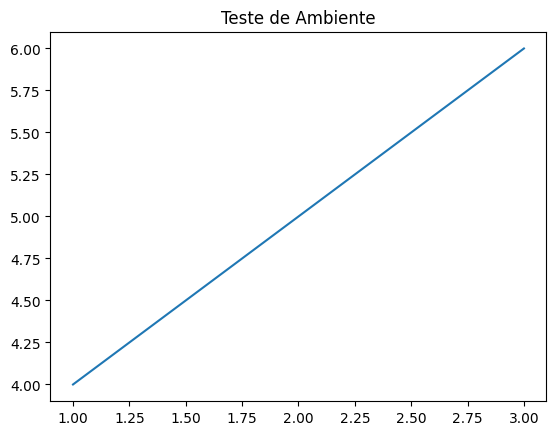

In [3]:
import pandas as pd
import numpy as np
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Pandas versão: {pd.__version__}")
print(f"SQLAlchemy versão: {sqlalchemy.__version__}")

plt.plot([1, 2, 3], [4, 5, 6])
plt.title("Teste de Ambiente")
plt.show()



In [4]:
import os
from dotenv import load_dotenv

# Carrega as variáveis do arquivo .env 
load_dotenv('../.env')

# acessar os valores como se fossem variáveis do sistema
usuario = os.getenv('DB_USER')
senha = os.getenv('DB_PASS')
host = os.getenv('DB_HOST')
banco = os.getenv('DB_NAME')

print(f"Conectando ao banco {banco} como o usuário {usuario}...")

Conectando ao banco meu_projetohelpdesk como o usuário root...


In [13]:
from sqlalchemy import create_engine

#  variáveis configuradas 
DB_USER = 'root'
DB_PASS = 'spfc1930'
DB_HOST = 'localhost'
DB_PORT = '3306'
DB_NAME = 'meu_projetohelpdesk'

# 2. Montagem da URL usando os nomes novos (f-string)
# Mude para mysql+pymysql
url_conexao = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# 3. Criando o motor de conexão
engine = create_engine(url_conexao)

# 4. Teste de conexão real
try:
    with engine.connect() as conexao:
        print("✅ Conexão realizada com sucesso!")
        print(f"Conectado ao banco: {DB_NAME}")
except Exception as e:
    print(f"❌ Erro ao conectar: {e}")

✅ Conexão realizada com sucesso!
Conectado ao banco: meu_projetohelpdesk


In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

np.random.seed(42)
n_chamados = 1000 
hoje = datetime.now()

data = {
    'id_ticket': range(1, n_chamados + 1),
    'data_abertura': [hoje - timedelta(days=np.random.randint(1, 30), hours=np.random.randint(1, 24)) for _ in range(n_chamados)],
    'categoria': np.random.choice(['Redes', 'Hardware', 'Software', 'Acessos', 'E-mail'], n_chamados, p=[0.1, 0.2, 0.4, 0.2, 0.1]),
    'agente': np.random.choice(['Ana', 'Carlos', 'Beatriz', 'Marcos'], n_chamados),
    'status': np.random.choice(['Concluído', 'Reaberto', 'Em andamento'], n_chamados, p=[0.7, 0.1, 0.2]),
}

df_helpdesk = pd.DataFrame(data)

df_helpdesk['horas_resolucao'] = np.where(
    df_helpdesk['categoria'] == 'Software', 
    np.random.uniform(10, 72, n_chamados), 
    np.random.uniform(1, 24, n_chamados)
)

df_helpdesk.to_sql('base_helpdesk', con=engine, if_exists='replace', index=False)
    
    

1000

In [20]:
query = "SELECT * FROM base_helpdesk"
# Mude de engine_mysql para engine
df = pd.read_sql(query, con=engine) 

tempo_medio_geral = df['horas_resolucao'].mean()
gargalo_categoria = df.groupby('categoria')['horas_resolucao'].mean().sort_values(ascending=False)



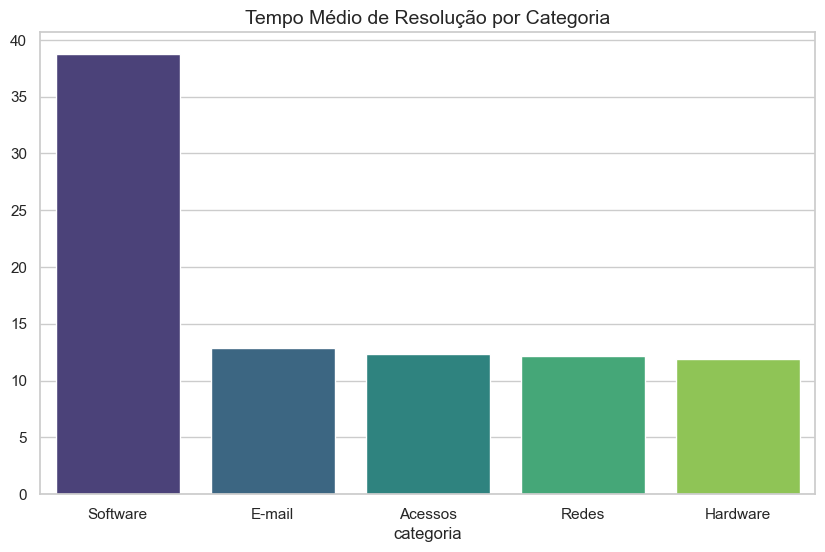

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Definir o estilo visual do gráfico
sns.set_theme(style="whitegrid")

# 2. Criar a figura (o "papel") e definir o tamanho
plt.figure(figsize=(10, 6))

#comando que desenha as barras
sns.barplot(
    x=gargalo_categoria.index, 
    y=gargalo_categoria.values, 
    hue=gargalo_categoria.index, 
    palette="viridis", 
    legend=False                 
)

#comando que limpa o lixo de memória e projeta a imagem final
plt.title('Tempo Médio de Resolução por Categoria', fontsize=14)
plt.show()

In [8]:
import numpy as np

# 1. Criando a coluna de Satisfação (notas de 1 a 5)
# p=[...] define que 40% das notas serão 5 (excelente) e apenas 5% serão 1 (muito ruim)
df['satisfacao_cliente'] = np.random.choice([1, 2, 3, 4, 5], len(df), p=[0.05, 0.10, 0.15, 0.30, 0.40])

# 2. Criando a coluna de Reaberturas (quantas vezes o ticket voltou)
# p=[...] define que 80% dos tickets não voltam (0), 15% voltam uma vez e 5% voltam duas vezes
df['reaberturas'] = np.random.choice([0, 1, 2], len(df), p=[0.80, 0.15, 0.05])

# 3. Cruzamento de dados: Qual a nota média quando o ticket é reaberto?
analise_satisfacao = df.groupby('reaberturas')['satisfacao_cliente'].mean()

print("✅ Colunas 'satisfacao_cliente' e 'reaberturas' criadas com sucesso!")
print("\n📊 Média de satisfação baseada no número de reaberturas:")
print(analise_satisfacao)

✅ Colunas 'satisfacao_cliente' e 'reaberturas' criadas com sucesso!

📊 Média de satisfação baseada no número de reaberturas:
reaberturas
0    3.913520
1    4.014706
2    3.976744
Name: satisfacao_cliente, dtype: float64


In [9]:
# 1. Contar quantos clientes deram cada nota (1 a 5)
contagem_notas = df['satisfacao_cliente'].value_counts().sort_index()

print("📊 Quantidade de clientes por nota:")
print(contagem_notas)

# 2. Ver a distribuição das notas dentro de cada grupo de reabertura (Tabela Cruzada)
tabela_cruzada = pd.crosstab(df['reaberturas'], df['satisfacao_cliente'])

print("\n📋 Tabela Cruzada: Reaberturas vs Notas (Contagem Real)")
print(tabela_cruzada)

📊 Quantidade de clientes por nota:
satisfacao_cliente
1     56
2     98
3    131
4    290
5    425
Name: count, dtype: int64

📋 Tabela Cruzada: Reaberturas vs Notas (Contagem Real)
satisfacao_cliente   1   2    3    4    5
reaberturas                              
0                   43  84  114  240  340
1                   11  11   11   35   68
2                    2   3    6   15   17


In [10]:
# Salvando a base completa e atualizada
try:
    df.to_sql('base_helpdesk_final', con=engine, if_exists='replace', index=False)
    print("✅ Sucesso! A tabela 'base_helpdesk_final' foi salva no MySQL Workbench.")
except Exception as e:
    print(f"❌ Erro ao salvar: {e}")

✅ Sucesso! A tabela 'base_helpdesk_final' foi salva no MySQL Workbench.
